In [1]:
import os
import sys

import torch
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# TODO: Fix sibling directory imports
cwd = os.path.dirname(os.getcwd())
sys.path.append(os.path.join(cwd, '..'))

from src.datautils.sandia import SandiaDataProvider
from src.utils import show_batch_of_images
from src.models import mlp_net as mlp



In [2]:
def pca_zm_proj(X, K=None):
    """return PCA projection matrix for zero mean data

    Inputs:
        X N,D design matrix of input features -- must be zero mean
        K     how many columns to return in projection matrix

    Outputs:
        V D,K matrix to apply to X or other matrices shifted in same way.
    """
    if np.max(np.abs(np.mean(X,0))) > 1e-3:
        raise ValueError('Data is not zero mean.')
    if K is None:
        K = X.shape[1]
    E, V = np.linalg.eigh(np.dot(X.T, X))
    idx = np.argsort(E)[::-1]
    V = V[:, idx[:K]] # D,K
    return V

## Get data

In [3]:
img_size = 28

train_data = SandiaDataProvider(which_set='train', dataset_home='../../datasets/sandia/', img_size=28)
test_data = SandiaDataProvider(which_set='test', dataset_home='../../datasets/sandia/', img_size=28)

# These are in the shape <num_questions, imsize, imsize, 16(8Q + 8A)> - transpose and reshape so that they are
# in the shape <num_images, img_size **2 >
X = train_data.inputs.transpose(3, 0, 1, 2).reshape(-1, img_size ** 2)
X_test = test_data.inputs.transpose(3, 0, 1, 2).reshape(-1, img_size ** 2)

Check that we're reshaping the data correctly - we should have the images as row vectors

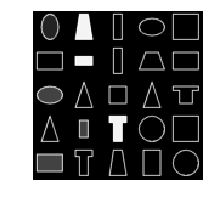

In [4]:
fig = plt.figure(figsize=(3,3))
show_batch_of_images(X[:25].reshape(25, img_size, img_size), fig);

## Center data

In [5]:
mu = np.mean(X, axis=0)
X_centered = X - mu

## Obtain projection matrix

In [6]:
V = pca_zm_proj(X_centered)
print(V.shape)

(784, 784)


## Plot projection onto first two principal components

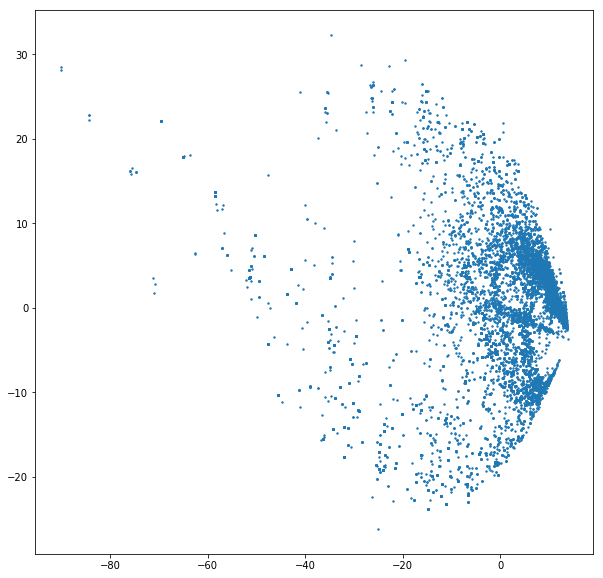

In [7]:
X2d = X_centered @ V[:, :2]

plt.figure(figsize=(10, 10))
plt.scatter(X2d[:, 0], X2d[:, 1], s=2);

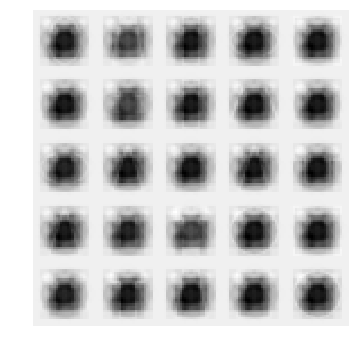

In [8]:
comp = 0

X_proj = X_centered @ V
X_rec = X_proj @ V.T + mu

std = np.std(X_proj[:, comp])
X_pert = X_centered @ V
X_pert[:, comp] += 25 * std

X_rec1 = X_pert @ V.T + mu

show_batch_of_images(X_rec1[:25].reshape(-1, img_size, img_size), plt.figure(figsize=(5,5)));

# Do the same thing with our class

In [9]:
from src.autoencoders import PCA_autoencoder

enc = PCA_autoencoder()
enc.train(X)

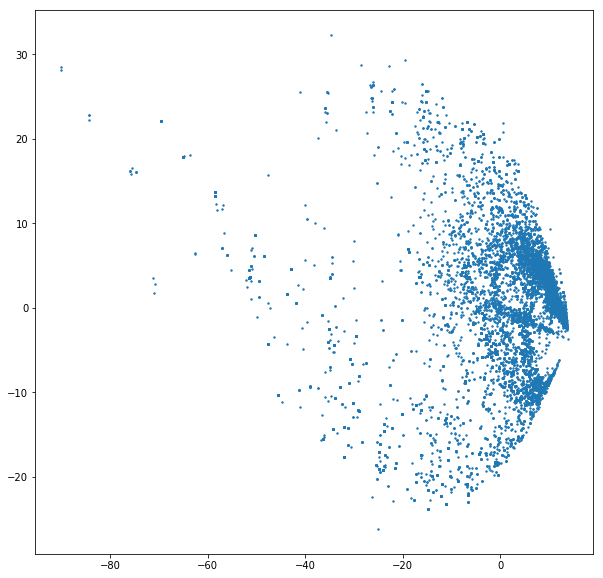

In [10]:
X2d = enc.encode(X, 2)

plt.figure(figsize=(10, 10))
plt.scatter(X2d[:, 0], X2d[:, 1], s=2);

## Make sure decoding works on training data

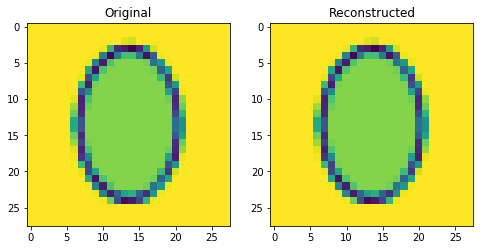

In [28]:
X_enc = enc.encode(X, img_size ** 2)
X_dec = enc.decode(X_enc)
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(X[0].reshape(img_size, img_size))
axs[0].set_title('Original')
axs[1].imshow(X_dec[0].reshape(img_size, img_size));
axs[1].set_title('Reconstructed');

# Try encoding test data

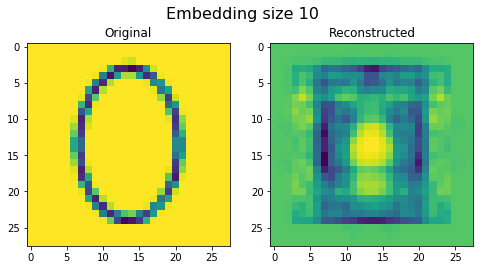

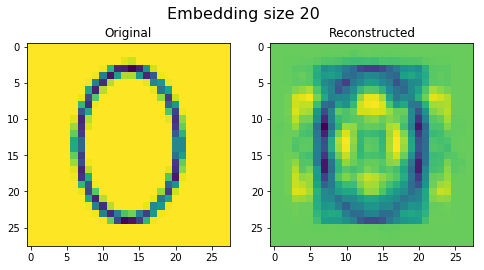

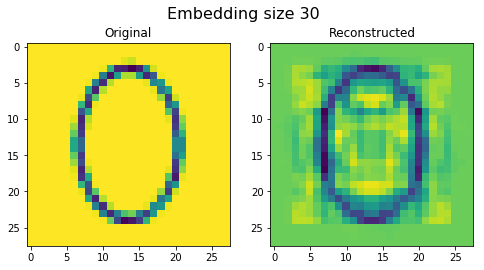

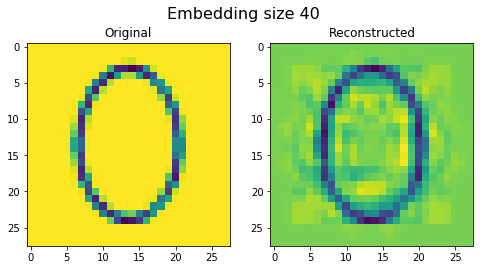

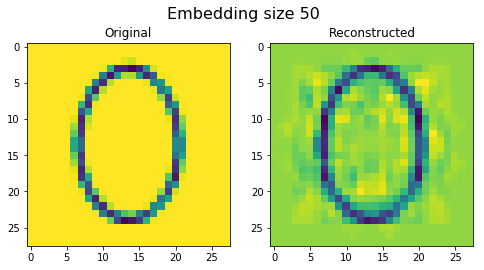

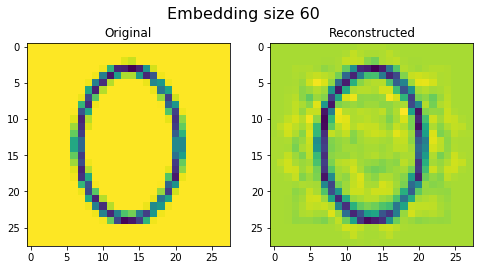

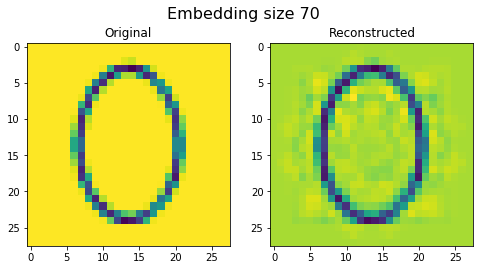

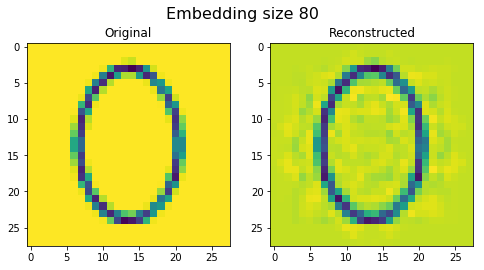

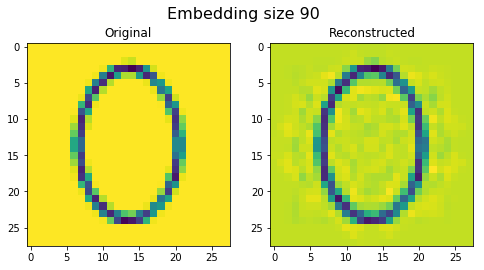

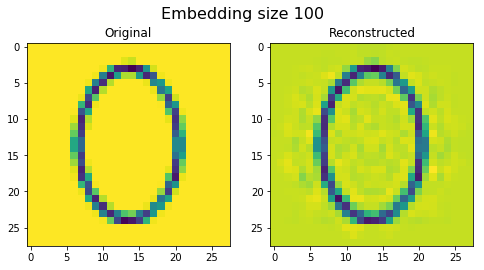

In [12]:
img_id = 18
for emb_size in range(10, 110, 10):
    test_enc = enc.encode(X_test, emb_size)
    test_dec = enc.decode(test_enc)
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    plt.suptitle(f'Embedding size {emb_size}', fontsize=16)
    axs[0].imshow(X_test[img_id].reshape(img_size, img_size))
    axs[0].set_title('Original')
    axs[1].imshow(test_dec[img_id].reshape(img_size, img_size));
    axs[1].set_title('Reconstructed');

## Measure MSE on test data

CPU times: user 21.4 s, sys: 806 ms, total: 22.2 s
Wall time: 5.69 s


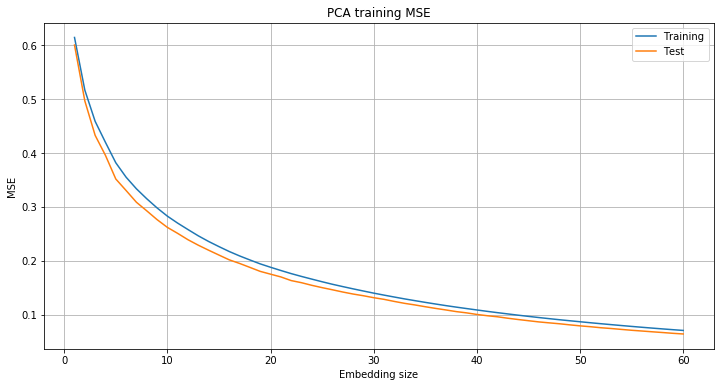

In [192]:
%%time
sizes = []
train_losses = []
test_losses = []
for emb_size in range(1, 61):
    test_enc = enc.encode(X_test, emb_size)
    test_dec = enc.decode(test_enc)
    
    train_enc = enc.encode(X, emb_size)
    train_dec = enc.decode(train_enc)
    
    sizes.append(emb_size)
    test_losses.append(np.mean((X_test - test_dec) ** 2))
    train_losses.append(np.mean((X - train_dec) ** 2))
    
plt.figure(figsize=(12, 6))
plt.title('PCA training MSE')
plt.xlabel('Embedding size')
plt.ylabel('MSE')
plt.grid()
plt.plot(sizes, train_losses, label='Training');
plt.plot(sizes, test_losses, label='Test');
plt.legend();

# Train on encoded data

In [13]:
xx = enc.encode(X_test, 60)

In [14]:
train_data.inputs.shape
batch_iterator = train_data.get_batch_iterator(160)

In [15]:
inputs , targets = next(batch_iterator)
(inputs.shape, targets.shape)

((152, 28, 28, 16), (152,))

In [16]:
train_images = inputs[:,:,:,:8]
yy = np.zeros((inputs.shape[0],inputs.shape[1],inputs.shape[2],1))
for i in range(yy.shape[0]):
    yy[i] = inputs[i,:,:,(7 + targets[i]),None] #TODO - change 7 tp 8 after sync with yasen's code
(train_images.shape, yy.shape)

((152, 28, 28, 8), (152, 28, 28, 1))

In [17]:
batch_iterator = train_data.get_batch_iterator(160)
for batch in batch_iterator:
    inputs , targets = batch
inputs.shape, targets.shape

((151, 28, 28, 16), (151,))

In [190]:
# Model parameters
pce_dim = 10
D_in,D_out = pce_dim * 8, pce_dim
hidden_s,hidden_n = 1000, 9
batch_size = 200

epochs = 101
learning_rate = 1e-4

# Get first datapoints : Don't need that atm
# xx = Variable(torch.randn(8 ,50)) # get next x
# D_out = xx.shape[1]
# D_in = D_out * xx.shape[0]

# xx_flat = xx.view(D_in)
# yy = torch.sum(xx, 0) # get next y

# xx_flat.cuda()
# yy.cuda()

#Initialize the network and loss
# model = mlp.Net(D_in, D_out, hidden_s,hidden_n)
# model.cuda()


#Train
layers = [1000]
for layer__size in layers:
    model = mlp.Net(D_in, D_out,hidden_n,layer__size)
    criterion = torch.nn.MSELoss(size_average=False)
    optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, weight_decay=1e-5)
    for epoch in range(epochs):
        for j, batch in enumerate(train_data.get_batch_iterator(160)):
            #load and transform data
            #inputs - first 8 images from each 16, yy the correct answer to the seq
            images , correct_ans = batch
            inputs = images[:,:,:,:8]
            yy = np.zeros((images.shape[0],images.shape[1],images.shape[2],1))
            for i in range(yy.shape[0]):
                yy[i] = images[i,:,:,(7 + correct_ans[i]),None] #TODO - change 7 to 8 after sync with yasen's code

            inputs = inputs.transpose(3, 0, 1, 2).reshape(-1, img_size ** 2)
            inputs = enc.encode(inputs, pce_dim)
            inputs = inputs.reshape(-1, inputs.shape[1] * 8)    

            answers = yy.transpose(3, 0, 1, 2).reshape(-1, img_size ** 2)
            answers = enc.encode(answers, pce_dim)

            xx = Variable(torch.from_numpy(inputs).float())
            yy = Variable(torch.from_numpy(answers).float())

            y_pred = model(xx)
            loss = criterion(y_pred, yy)
    #         if i%10 is 0 and j == 1:
    #             print(i,loss.data[0])

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if epoch%20 == 0:
            print(layer__size, epoch, loss.data[0])
    torch.save(model, '{}layers_reg.pt'.format(hidden_n))

1000 0 85558.6328125
1000 20 94024.7890625
1000 40 85808.453125
1000 60 79831.09375
1000 80 80833.5703125
1000 100 83941.46875


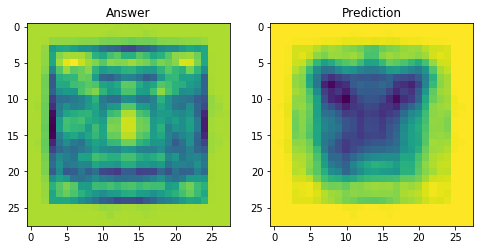

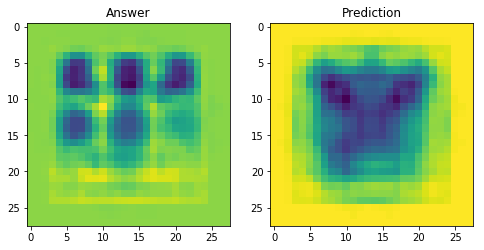

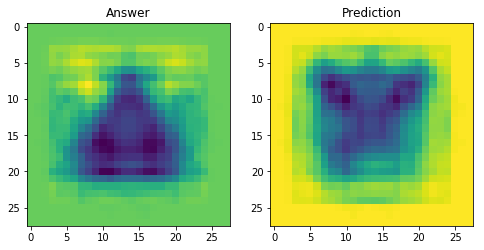

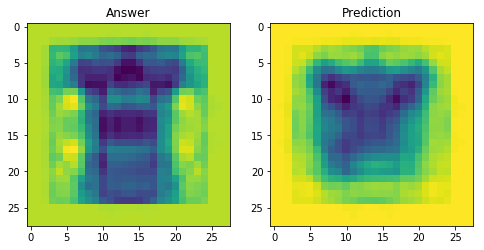

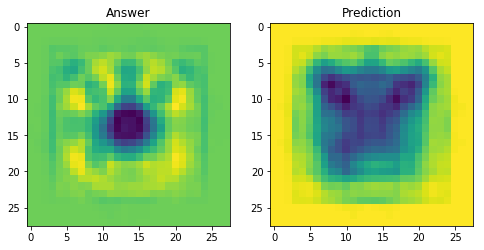

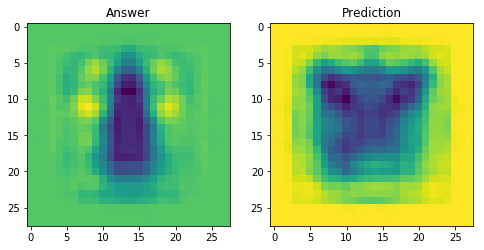

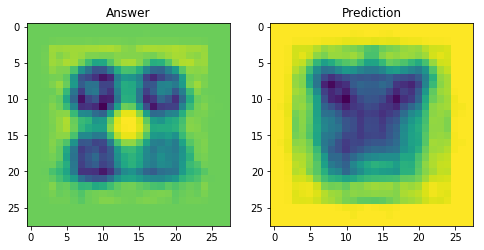

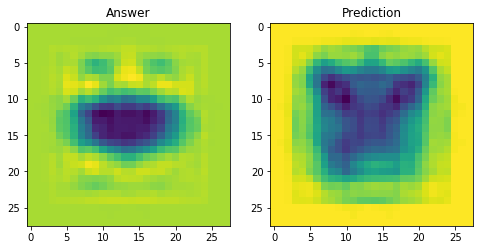

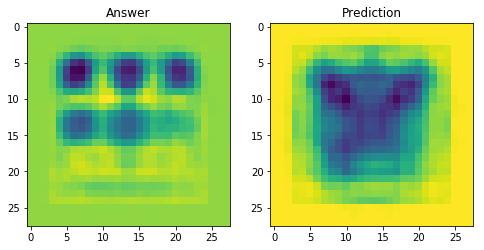

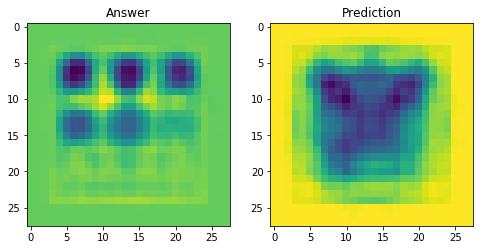

In [134]:
# X_enc = enc.encode(X, img_size ** 2)
my_pred = enc.decode(y_pred.data.numpy())
answer = enc.decode(answers)
for i in range(10):
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(answer[i].reshape(img_size, img_size))
    axs[0].set_title('Answer')
    axs[1].imshow(my_pred[i].reshape(img_size, img_size));
    axs[1].set_title('Prediction');

In [191]:
def MSE(Y, YH):
    return np.square(Y - YH).mean()

y_pred
all_answers = images[:,:,:,8:]
all_answers = all_answers.transpose(3, 0, 1, 2).reshape(-1, img_size ** 2)
all_answers = enc.encode(all_answers, pce_dim)
all_answers = all_answers.reshape(-1, 8, all_answers.shape[1])   
my_pred = y_pred.data.numpy()

counter = 0
for i in range(correct_ans.shape[0]):
    distances = [None] * 8
    for j in range(8):
        distances[j] = MSE(all_answers[i,j],my_pred[i])
    predicted =  distances.index(min(distances)) + 1
    if correct_ans[i] - predicted == 0:
        counter += 1

    
print(counter, counter / correct_ans.size)

20 0.13245033112582782


In [182]:
correct_ans.size

151

In [135]:
test_data